# Creating a global map using foscat from a single model

## Authors & Contributors

### Authors

- Jean-Marc Delouis, LOPS - Laboratoire d'Oceanographie Physique et Spatiale UMR 6523 CNRS-IFREMER-IRD-Univ.Brest,
- Tina Odaka, Laboratoire d'Oceanographie Physique et Spatiale UMR 6523 CNRS-IFREMER-IRD-Univ.Brest,

## Context

This notebook demonstrates the use of FOSCAT packages to synthesize new maps from an initial target map. The synthesized maps retain the same Scattering Covariance (SC) statistics as the target map. The target map is here a Large Scale Structure simulation of weak lensing, from the CosmoGrid data set (Kacprzak et al. 2023; Fluri et al. 2022); utilized in this example is identical to the one in Mousset et al. (submitted 2024), and the synthesis method is nearly the same.

### The method

The idea is to calculate the SC statistic $\Phi(d)$ for the target map $d$ and generate a new map $u$ that minimizes the following loss:
$L = \sum_k{\frac{(\Phi(d)_k - \Phi(u)_k)^{2}}{\sigma_k^{2}}}$

Here, $k$ denotes the $k^{th}$ SC coefficients, and $\sigma_k^{2}$ represents the variance of $\Phi(d)_k$ across the target map. Specifically, $\Phi(d)_k$ values are obtained by integrating over the entire domain wavelet maps, while $\sigma_k^{2}$ values correspond to the variance within this domain.

The map $u$ is initially set to random Gaussian noise, and the final result is obtained by iteratively minimizing $L$ using gradient descent. The resulting map $u$ is then returned.

### For further details on the synthesis domain, please refer to:

Fluri, J., Kacprzak, T., Lucchi, A., et al. 2022, Phys. Rev. D, 105, 083518 

Kacprzak, T., Fluri, J., Schneider, A., Refregier, A., & Stadel, J. 2023, Journal of Cosmology and Astroparticle Physics, 2023, 05 

Mousset, L., Allys E.,  Pric, M. A., . Aumo, J., Delouis, J.-M., Montier, L., McEwen, J. D., Sumitted 2024 Astronomy & Astrophysic

## Installation of required packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import foscat.scat_cov as sc
import foscat.Synthesis as synthe

## Convert Data in HEALPix

The above gap-filling method does not take into account that our subject is a sphere. Because we work with full globe data, we need to treat the grid system that conveys the shape of the sphere. To do that, we use one of the Discrete Global Grid Systems (DGGS), HEALPix.

HEALPix stands for Hierarchical Equal Area isoLatitude Pixelation of a sphere. This pixelation produces a subdivision of a spherical surface in which each pixel covers the same surface area as every other pixel. 
![HEALPix](https://healpix.sourceforge.io/images/gorski_f1.jpg)

See [https://healpix.sourceforge.io](https://healpix.sourceforge.io) and/or [the HEALPix Primer](https://healpix.jpl.nasa.gov/pdf/intro.pdf) for more information.

The [healpy tutorial](https://healpy.readthedocs.io/en/latest/tutorial.html#NSIDE-and-ordering) is also a very good starting point to understand more about HEALPix.

### Resolution
The resolution of the grid is expressed by the parameter `Nside`, which defines the number of divisions along the side of a base-resolution pixel that is needed to reach a desired high-resolution partition.

### Ordering Systems

HEALPix supports two pixel ordering systems: `nested` and `ring`.

Detailed explanations of the two pixel ordering systems can be found at [https://healpix.jpl.nasa.gov/html/intronode4.htm](https://healpix.jpl.nasa.gov/html/intronode4.htm).

In our exam

### choose the resolution

we use $nside=64$ in this context to prevent excessive computation.ple we use `nested` 

In [3]:
nside=64

### Get Large Scale Structure data

The target map is here a LSS simulation of weak lensing, from the CosmoGrid data set (Kacprzak et al. 2023; Fluri et al. 2022); 

In [4]:
!wget -O target_map_lss.npy https://github.com/astro-informatics/s2scat/raw/main/notebooks/data/target_map_lss.npy

--2025-09-03 10:07:40--  https://github.com/astro-informatics/s2scat/raw/main/notebooks/data/target_map_lss.npy
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/astro-informatics/s2scat/main/notebooks/data/target_map_lss.npy [following]
--2025-09-03 10:07:40--  https://raw.githubusercontent.com/astro-informatics/s2scat/main/notebooks/data/target_map_lss.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8001::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1046656 (1022K) [application/octet-stream]
Saving to: ‘target_map_lss.npy’

target_map_lss.npy  100%[===================>]   1022K  --.-KB/s    in 0.08s   

2025-09-03 10:07:40 (1

In [5]:
from scipy.interpolate import RegularGridInterpolator

# convert the input data in a nside=128 healpix map
l_nside=128

im = np.load('target_map_lss.npy')
xsize,ysize=im.shape

# Define the new row and column to be added to prepare the interpolation
new_row = im[0:1,:]  # A new row with N elements (the other longitude)
new_column = np.concatenate([im[:,0:1],im[-2:-1,0:1]],0)  # A new column with N+1 elements to add previous latitude

# Add the new row to the array
im = np.vstack([im, new_row])

# Add the new column to the array with the new row

im = np.hstack([im, new_column])

# Create a grid of coordinates corresponding to the array indices
x = np.linspace(0, im.shape[0]-1, im.shape[0])
y = np.linspace(0, im.shape[1]-1, im.shape[1])

# Create an interpolator
interpolator = RegularGridInterpolator((x, y), im)

# List of healpix coordinate to interpol
colatitude,longitude = hp.pix2ang(l_nside,np.arange(12*l_nside**2),nest=True)
coords = np.concatenate([colatitude/np.pi*xsize,longitude/(2*np.pi)*ysize],0).reshape(2,colatitude.shape[0]).T

# Perform the interpolation
heal_im = interpolator(coords)

#reduce the final map to the expected resolution
if nside>128:
    th,ph=hp.pix2ang(nside,np.arange(12*nside**2),nest=True)
    heal_im=hp.get_interp_val(heal_im,th,ph,nest=True)
else:
    heal_im=np.mean(heal_im.reshape(12*nside**2,(l_nside//nside)**2),1)

# free memory
del coords
del interpolator
del colatitude
del longitude

### Initialise FOSCAT scattering covariance description

In [6]:
scat_op=sc.funct(
                NORIENT=4,          # define the number of wavelet orientation
                KERNELSZ=5,         #KERNELSZ,  define the kernel size
                )

### Compute the reference statistics

In [7]:
scat_op.clean_norm()
ref=scat_op.eval(heal_im,calc_var=True,norm='auto')
ref,sref=scat_op.eval(heal_im,calc_var=True,norm='auto')

/srv/conda/envs/notebook/lib/python3.12/site-packages/foscat/BkTorch.py:349: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1750199048837/work/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  return self.backend.sparse_coo_tensor(indice.T, w, dense_shape).to_sparse_csr().to(self.torch_device)
/srv/conda/envs/notebook/lib/python3.12/site-packages/foscat/BkTorch.py:768: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /home/conda/feedstock_root/build_artif

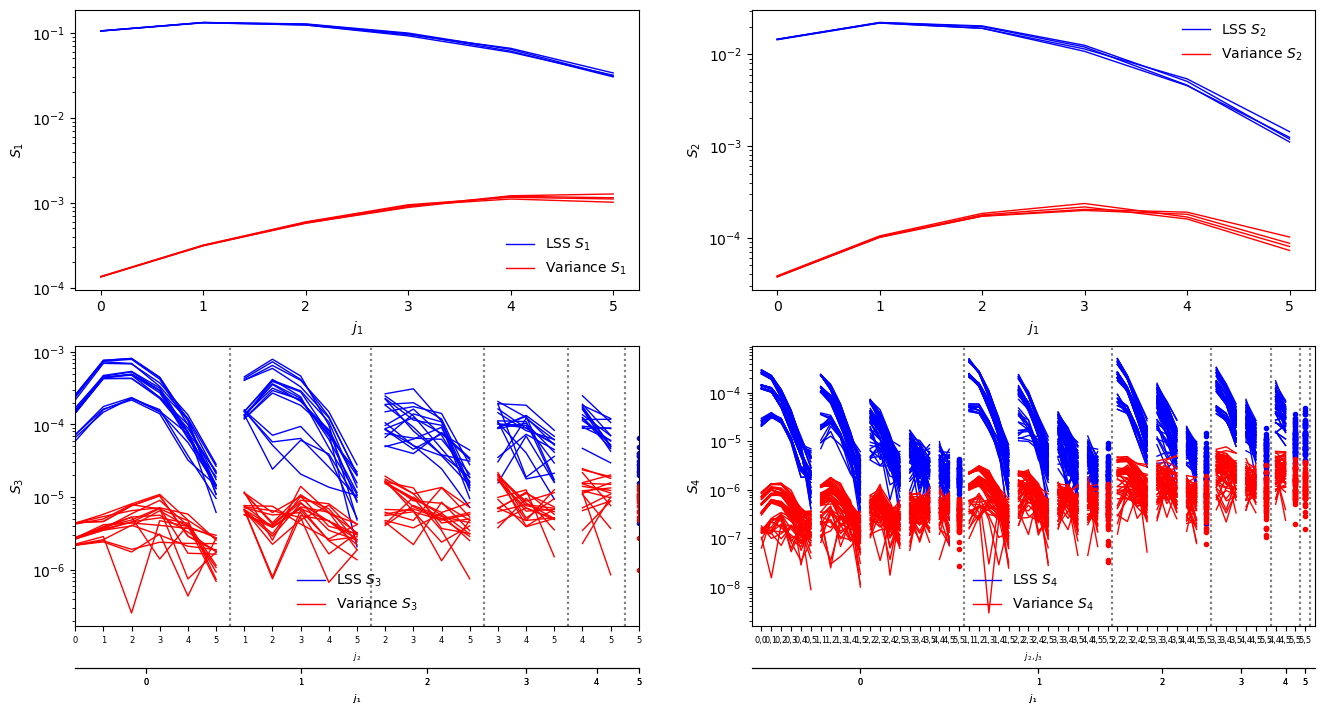

In [8]:
ref.plot(name='LSS',color='b')
sref.plot(name='Variance',color='r',hold=False)

In [28]:
imap,_=scat_op.ud_grade_2(scat_op.backend.bk_cast(heal_im))
omap=scat_op.synthesis(imap.cpu().numpy(),     # input target
                        nstep=1,               # number of scale for synthesis computation
                        to_gaussian=False, 
                       NUM_EPOCHS=500
                      )

Synthesis scale nside=32
Total number of loss  1
Itt      0 L=   3.8e+04 (   3.8e+04 ) 0.108s 
Itt    100 L=      5.25 (      5.25 ) 11.623s 
Itt    200 L=      2.14 (      2.14 ) 12.626s 
Itt    300 L=      1.35 (      1.35 ) 12.697s 
Itt    400 L=      1.01 (      1.01 ) 12.999s 
Itt    500 L=     0.834 (     0.834 ) 13.146s 
Final Loss  0.834492027759552
Total computation 63.38s


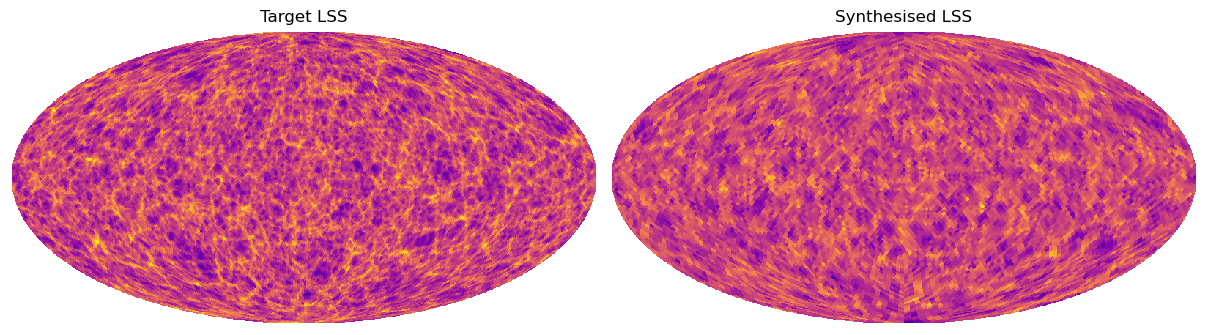

In [30]:
plt.figure(figsize=(12,10))
hp.mollview(heal_im,cmap='plasma',nest=True,title='Target LSS',min=-3,max=3,
            hold=False,sub=(1,2,1),cbar=False)
hp.mollview(omap,cmap='plasma',nest=True,title='Synthesised LSS',min=-3,max=3,
            hold=False,sub=(1,2,2),cbar=False)

## do synthesis with user's loss function¶

In [ ]:
scat_op.clean_norm()
ref=scat_op.eval(heal_im,calc_var=True,norm='auto')
ref,sref=scat_op.eval(heal_im,calc_var=True,norm='auto')

In [16]:
def The_loss(u,scat_operator,args):
    ref  = args[0]
    sref = args[1]

    # compute scattering covariance of the current synthetised map called u
    learn=scat_operator.eval(u,norm='auto')

    # make the difference withe the reference coordinates
    loss=scat_operator.reduce_distance(learn,ref,sigma=sref)

    return(loss)

### Build the synthesis model

In [17]:
loss1=synthe.Loss(The_loss,scat_op,ref,sref)

sy = synthe.Synthesis([loss1])

### Run the synthesis

In [18]:
imap=np.random.randn(12*nside**2)*np.std(heal_im)

inscat=scat_op.eval(imap,norm='auto')

omap=scat_op.backend.to_numpy(sy.run(imap,
                            EVAL_FREQUENCY=100,
                            NUM_EPOCHS = 500))

Total number of loss  1
Itt      0 L=  1.97e+04 (  1.97e+04 ) 0.412s 
Itt    100 L=      71.8 (      71.8 ) 43.891s 
Itt    200 L=      22.6 (      22.6 ) 45.126s 
Itt    300 L=      11.1 (      11.1 ) 45.769s 
Itt    400 L=      7.07 (      7.07 ) 71.395s 
Itt    500 L=      4.99 (      4.99 ) 79.918s 
Final Loss  4.988753318786621


### Plot the results

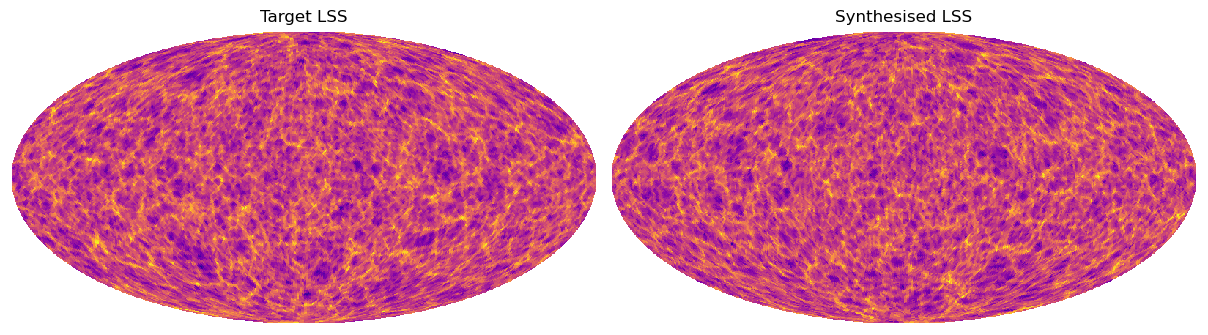

In [19]:
plt.figure(figsize=(12,10))
hp.mollview(heal_im,cmap='plasma',nest=True,title='Target LSS',min=-3,max=3,
            hold=False,sub=(1,2,1),cbar=False)
hp.mollview(omap,cmap='plasma',nest=True,title='Synthesised LSS',min=-3,max=3,
            hold=False,sub=(1,2,2),cbar=False)

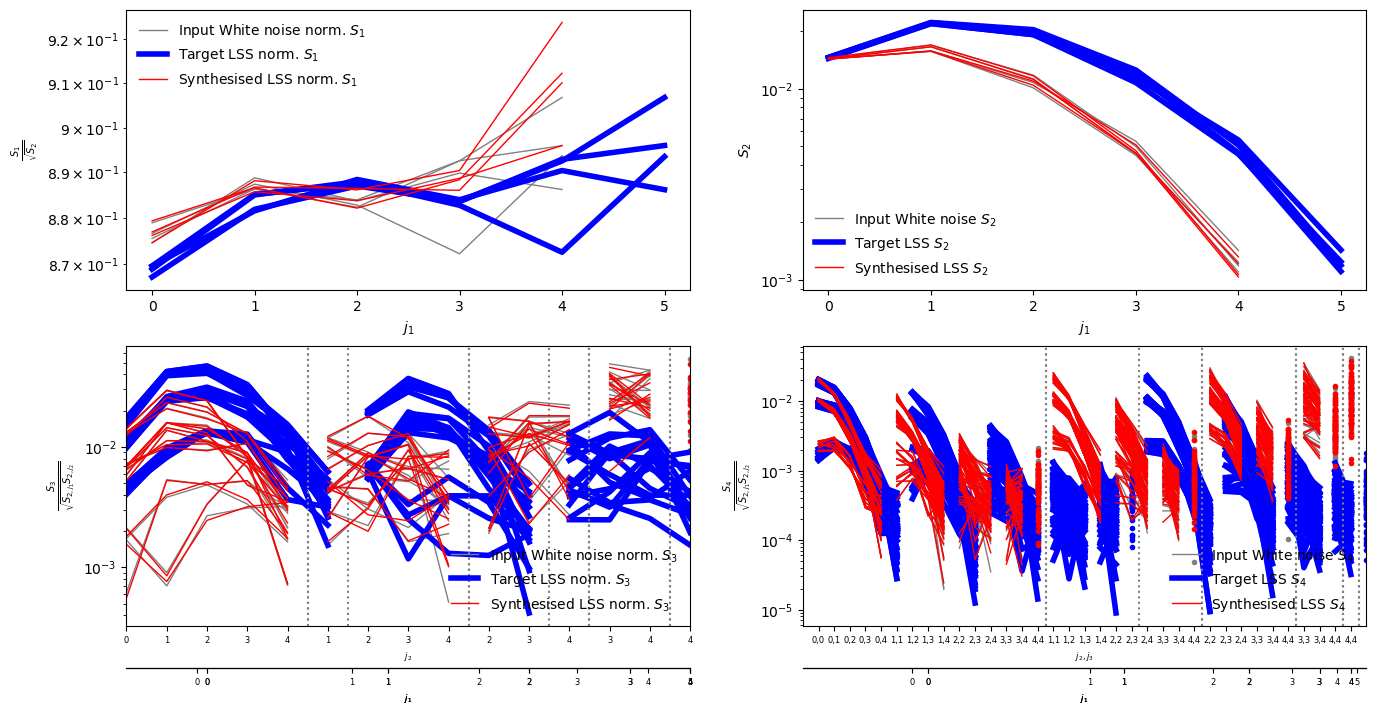

In [24]:
synth=scat_op.eval(omap,norm='self')
inscat=scat_op.eval(imap,norm='self')
inscat.plot(name='Input White noise',color='grey',norm=True)
ref.plot(name='Target LSS',color='b',norm=True,lw=4,hold=False)
synth.plot(name='Synthesised LSS',color='r',hold=False,norm=True)

### Emulate an ensemble

By employing the earlier paradigm, one can synthesize multiple images with the appropriate statistical properties. Observe the slight change of computational time compare to single image synthesis, attributed to the GPU's capability to perform image statistical computations in a massively parallel manner.

In [ ]:
omap=scat_op.synthesis(heal_im,                # input target
                       nstep=1,                # number of scale for synthesis computation
                       NUM_EPOCHS=500,
                       synthesised_N=4)          # Number of synthesis

In [ ]:
plt.figure(figsize=(12,10))
hp.mollview(heal_im,cmap='plasma',nest=True,title='Target LSS',min=-3,max=3,
            hold=False,sub=(3,2,1),cbar=False)
for k in range(4):
    hp.mollview(omap[k],cmap='plasma',nest=True,title='Synthesised LSS #%d'%(k),min=-3,max=3,
                hold=False,sub=(3,2,3+k),cbar=False)

## equivalent with the user's loss function

In [ ]:
def The_loss_mean(u,scat_operator,args):
    ref  = args[0]
    sref = args[1]

    # compute the mean scattering covariance of the current synthetised maps called u
    learn=scat_operator.reduce_mean_batch(scat_operator.eval(u,norm='self'))
    
    # make the difference with the reference coordinates
    loss=scat_operator.reduce_mean(scat_operator.square((learn-ref)/sref))

    return(loss)

In [ ]:
loss_mean=synthe.Loss(The_loss_mean,scat_op,ref,sref)

sy_mean = synthe.Synthesis([loss_mean])

In [ ]:
imap=np.random.randn(4,12*nside**2)*np.std(heal_im)

omap=scat_op.backend.to_numpy(sy_mean.run(imap,
                            EVAL_FREQUENCY=100,
                            NUM_EPOCHS = 1000))

In [ ]:
plt.figure(figsize=(12,10))
hp.mollview(heal_im,cmap='plasma',nest=True,title='Target LSS',min=-3,max=3,
            hold=False,sub=(3,2,1),cbar=False)
for k in range(4):
    hp.mollview(omap[k],cmap='plasma',nest=True,title='Synthesised LSS #%d'%(k),min=-3,max=3,
                hold=False,sub=(3,2,3+k),cbar=False)

In [ ]:
plt.figure(figsize=(12,8))
ref.plot(name='Target LSS',color='grey',norm=True,lw=4,hold=False)

color=['b','r','orange','pink']
for k in range(4):
    synth=scat_op.eval(omap[k],norm='self')
    synth.plot(name='Synthesised LSS #%d'%(k),color=color[k],hold=False,norm=True)